In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
from diffSPH.v2.sampling import samplePDF

def pdf(x):
    return 2 + np.sin(2*np.pi*x)


In [10]:
config = {
    'domain': {
        'minExtent': -1,
        'maxExtent': 1,
        'dim': 1,
        'periodic': True
    },
    'particle': {
        'nx': 2**10
    },
    'kernel':{
        'name': 'Wendland2'
    },
    "neighborhood":{
        "scheme": "small"
    },
    'EOS':{
        'type': 'Tait',
        'kappa': 1.5
    }
}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)

display(config)

particles = samplePDF(pdf, plot = True, n = 2*config['particle']['nx'], numParticles = config['particle']['nx'])

{'domain': {'minExtent': tensor([-1.]),
  'maxExtent': tensor([1.]),
  'dim': 1,
  'periodic': True,
  'periodicity': tensor([True])},
 'particle': {'nx': 1024,
  'dx': tensor(0.0020),
  'support': tensor(0.0063),
  'defaultVolume': tensor(0.0020),
  'defaultSupport': tensor(0.0063),
  'volume': tensor(0.0020),
  'smoothingLength': tensor(0.0039)},
 'kernel': {'name': 'Wendland2',
  'targetNeighbors': tensor(6.4807),
  'function': <diffSPH.kernels.KernelWrapper at 0x7b4646bf1010>,
  'kernelScale': tensor(1.6202)},
 'neighborhood': {'scheme': 'small', 'verletScale': 1.5},
 'EOS': {'type': 'Tait',
  'kappa': 1.5,
  'gasConstant': 8.14,
  'molarMass': 0.02897,
  'polytropicExponent': 7},
 'compute': {'device': 'cpu', 'precision': 'float32', 'dtype': torch.float32},
 'simulation': {'correctArea': False,
  'supportScheme': 'symmetric',
  'densityScheme': 'continuity',
  'timestamp': '2024_06_04-14_23_44'},
 'fluid': {'rho0': 1000, 'mu': 0.1, 'cs': 10},
 'plot': {'mosaic': 'A',
  'figSize': 

In [11]:
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sphOps import sphOperation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from diffSPH.v2.math import volumeToSupport
from diffSPH.v2.sphOps import sphOperationStates

def resampleToGrid1D(simulationState, inQuantity, config, nGrid = 127):
    dx = (config['domain']['maxExtent'][0] - config['domain']['minExtent'][0]) / nGrid    
    x = torch.linspace(config['domain']['minExtent'][0] + dx/2, config['domain']['maxExtent'][0] - dx/2, nGrid).view(-1,1)
    dim = x.shape[1]
    vol = dx ** dim

    targetNeighbors = config['kernel']['targetNeighbors']
    support = volumeToSupport(vol, targetNeighbors, dim)
    xarea = torch.ones(x.shape[0]) * vol
    hx = torch.ones(x.shape[0]) * support

    i, j, rij, xij, hij, kernel, gradKernel = neighborSearch(
        x, simulationState['fluid']['positions'], hx, simulationState['fluidSupports'], 
        config['kernel']['function'], config['domain']['dim'],
        config['domain']['periodicity'].detach().cpu().numpy().tolist() , config['domain']['minExtent'], config['domain']['maxExtent'], mode = 'symmetric')
    # kernel = config['kernel']['function'].kernel(rij, hij, dim)
    # gradKernel = config['kernel']['function'].kernelGradient(rij, xij, hij, dim)

    rho = sphOperation((None, simulationState['fluidMasses']), (None, simulationState['fluidDensities']), (None, inQuantity), (i, j), kernel, gradKernel, 
                    rij, xij, hij, x.shape[0],operation = 'interpolate', gradientMode = 'difference')
    
    return x, rho

def scatterPlot(fig, axis, simulationState, c, label = None, cmap = 'viridis'):
    sc = axis.plot(simulationState['fluidPositions'][:,0], c)#, lw = 2, marker = 'x', markersize = 2, linestyle = '-')
    ax1_divider = make_axes_locatable(axis)
    # cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    # cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    # if p.shape[1] > 1:
        # square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        # axis.add_patch(square)
    # axis.set_aspect('equal')
    # axis.set_xlim(-1.05,1.05)
    # axis.set_ylim(-1.05,1.05)

In [12]:


perennialState = {'fluid':{}}

area = 2 / config['particle']['nx']
perennialState['fluid']['positions'] = particles
perennialState['fluid']['areas'] = particles.new_ones(particles.shape[0]) * 2 * area
perennialState['fluid']['masses'] = perennialState['fluid']['areas'] * config['fluid']['rho0']
perennialState['fluid']['supports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim'])
perennialState['fluid']['velocities'] = torch.zeros_like(particles)

perennialState['fluid']['numParticles'] = particles.shape[0]

perennialState['fluid']['neighborhood'] = neighborSearch(perennialState['fluid'], perennialState['fluid'], config)
perennialState['fluid']['densities'] = sphOperationStates(perennialState['fluid'], perennialState['fluid'], None, operation = 'density', neighborhood = perennialState['fluid']['neighborhood'])
_, perennialState['fluid']['NumNeighbors'] = countUniqueEntries(perennialState['fluid']['neighborhood']['indices'][0], perennialState['fluid']['positions'])

initialState = copy.deepcopy(perennialState)

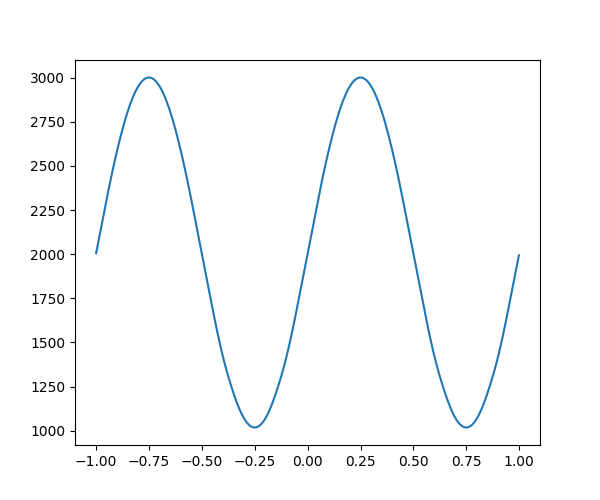

In [13]:

fig, axis = plt.subplots(1, 1, figsize = (6,5), squeeze = False)

# axis[0,0].scatter(particles[:,0], particles[:,0] * 0, s = 1)
axis[0,0].plot(perennialState['fluid']['positions'],perennialState ['fluid']['densities'])

In [14]:
import torch
from diffSPH.v2.math import scatter_sum
from typing import Dict, Optional, Union
from torch.profiler import record_function

@torch.jit.script 
def sphInterpolation(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int):                                                        # Ancillary information
    j = neighborhood[1]
    k = masses[1][j] / densities[1][j] * kernels
    kq = torch.einsum('n..., n -> n...', quantities[1][j] if isinstance(quantities,tuple) else quantities, k)
    
    return scatter_sum(kq, neighborhood[0], dim = 0, dim_size = numParticles)

@torch.jit.script 
def sphDensityInterpolation(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int):                                                        # Ancillary information
    j = neighborhood[1]
    kq = masses[1][j] * kernels
    
    return scatter_sum(kq, neighborhood[0], dim = 0, dim_size = numParticles)

@torch.jit.script
def sphOperation(
        masses : tuple[torch.Tensor, torch.Tensor],                                                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                                                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor, kernelGradients : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels and kernelGradients ij
        radialDistances : torch.Tensor, directions : torch.Tensor, supports : torch.Tensor,                         # Graph information of |x_j - x_i| / hij, (x_j - x_i) / |x_j - x_i| and hij
        numParticles : int,                                                                                         # Ancillary information
        operation : str = 'interpolate', gradientMode : str = 'symmetric', divergenceMode : str = 'div',
        kernelLaplacians : Optional[torch.Tensor] = None):           # Operation to perform
    with record_function("[SPH] - Operation [%s]" % operation):
        if operation == 'density':
            return sphDensityInterpolation(masses, densities, quantities, neighborhood, kernels, numParticles)
        if operation == 'interpolate':
            return sphInterpolation(masses, densities, quantities, neighborhood, kernels, numParticles)
        

    
def sphOperationStates(stateA, stateB, quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]], neighborhood: dict, operation : str = 'interpolate', gradientMode : str = 'symmetric', divergenceMode : str = 'div'):
    if operation == 'density':
        return sphDensityInterpolation(
            (stateA['masses'], stateB['masses']), 
            (stateA['masses'], stateB['masses']),
            (stateA['masses'], stateB['masses']), 
            neighborhood['indices'], 
            neighborhood['kernels'], 
            stateA['numParticles'])
    return sphOperation(
        (stateA['masses'], stateB['masses']), 
        (stateA['densities'], stateB['densities']),
        quantities, 
        neighborhood['indices'], 
        neighborhood['kernels'], neighborhood['gradients'], 
        neighborhood['distances'], neighborhood['vectors'], neighborhood['supports'], 
        stateA['numParticles'], 
        operation = operation, gradientMode = gradientMode, divergenceMode = divergenceMode, 
        kernelLaplacians = neighborhood['laplacians'] if 'laplacians' in neighborhood else None)

In [15]:
%%timeit

torchDensity = sphDensityInterpolation(
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']),
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    perennialState['fluid']['neighborhood']['indices'], 
    perennialState['fluid']['neighborhood']['kernels'], 
    perennialState['fluid']['numParticles']
)

# torchDensity = sphOperationStates(
#     perennialState['fluid'], perennialState['fluid'], None, 
#     operation = 'density', neighborhood = perennialState['fluid']['neighborhood'])

96.1 µs ± 82.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [59]:
from diffSPH.v2.compiler import compileSourceFiles

sphOperation_cpp = compileSourceFiles(
    ['/home/winchenbach/dev/diffSPH/sphOperations/cppOp.cpp', '/home/winchenbach/dev/diffSPH/sphOperations/cppOp.cu'], module_name = 'sphOperations', verbose = False, openMP = True, verboseCuda = False, cuda_arch = None)
# from torch.utils.cpp_extension import load

# sphOperation_cpp = load(name='sphOperations', sources=['/home/winchenbach/dev/diffSPH/partiBench/cppOp.cpp'], verbose = True, with_cuda = False, is_python_module = False, extra_cflags = ['-fopenmp'], extra_ldflags = ['-fopenmp'])
# sphDensity_cpp = sphOperation_cpp.sphDensity
sphInterpolation_cpp = sphOperation_cpp.sphInterpolation

In [60]:
# %%timeit

cppDensity = sphInterpolation_cpp(
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    (perennialState['fluid']['densities'], perennialState['fluid']['densities']),
    (perennialState['fluid']['densities'], perennialState['fluid']['densities']), 
    perennialState['fluid']['neighborhood']['indices'], 
    perennialState['fluid']['neighborhood']['kernels'], 
    perennialState['fluid']['numParticles'],
    perennialState['fluid']['neighborhood']['numNeighbors'],
    perennialState['fluid']['neighborhood']['neighborOffsets'],
)

In [61]:
masses_A = perennialState['fluid']['masses']
densities_A = perennialState['fluid']['densities']
quantities_A = perennialState['fluid']['densities'].clone()

kernels = perennialState['fluid']['neighborhood']['kernels']
neighborhood = perennialState['fluid']['neighborhood']['indices']
numParticles = perennialState['fluid']['numParticles']

# masses_A.requires_grad = True
# densities_A.requires_grad = True
# kernels.requires_grad = True

# masses_A.grad = None
# densities_A.grad = None
# kernels.grad = None

torchDensity = sphInterpolation(
    (masses_A, masses_A), 
    (densities_A, densities_A),
    (quantities_A, quantities_A), 
    neighborhood, 
    kernels, 
    numParticles
)


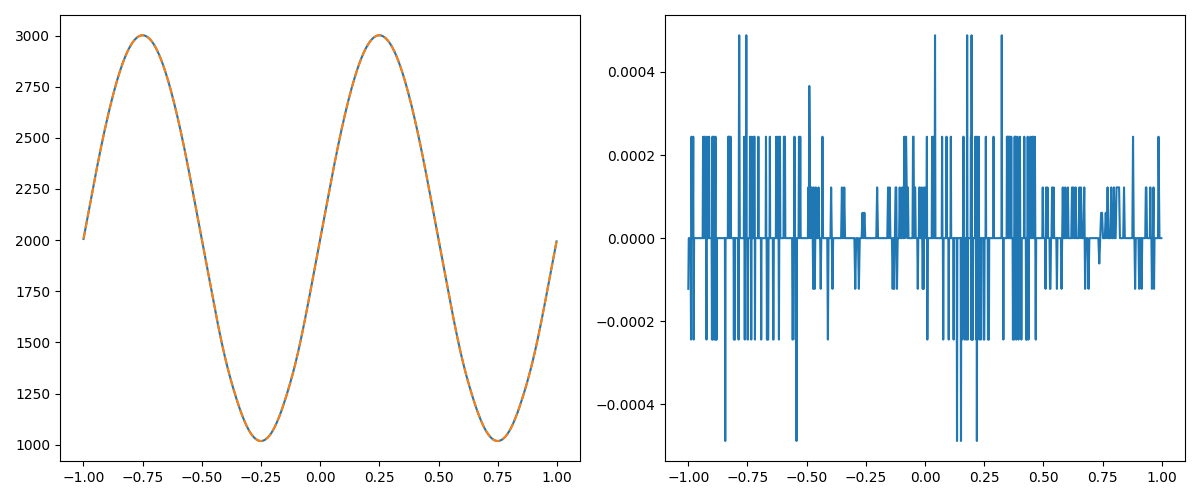

In [73]:
# print(torchDensity)
# print(cppDensity)


fig, axis = plt.subplots(1, 2, figsize = (12,5), squeeze = False)

# axis[0,0].scatter(particles[:,0], particles[:,0] * 0, s = 1)
axis[0,0].plot(perennialState['fluid']['positions'].detach().cpu().numpy(), torchDensity.detach().cpu().numpy())
axis[0,0].plot(perennialState['fluid']['positions'].detach().cpu().numpy(), cppDensity.detach().cpu().numpy(), ls = '--')

axis[0,1].plot(perennialState['fluid']['positions'].detach().cpu().numpy(), torchDensity.detach().cpu().numpy() - cppDensity.detach().cpu().numpy())

fig.tight_layout()

In [32]:

perennialState = {'fluid':{}}

area = 2 / config['particle']['nx']
perennialState['fluid']['positions'] = copy.deepcopy(particles)
perennialState['fluid']['areas'] = particles.new_ones(particles.shape[0]) * 2 * area
perennialState['fluid']['masses'] = perennialState['fluid']['areas'] * config['fluid']['rho0']
perennialState['fluid']['supports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim'])
perennialState['fluid']['velocities'] = torch.zeros_like(particles)

perennialState['fluid']['numParticles'] = particles.shape[0]


perennialState['fluid']['neighborhood'] = neighborSearch(perennialState['fluid'], perennialState['fluid'], config)
perennialState['fluid']['densities'] = sphOperationStates(perennialState['fluid'], perennialState['fluid'], None, operation = 'density', neighborhood = perennialState['fluid']['neighborhood'])
_, perennialState['fluid']['NumNeighbors'] = countUniqueEntries(perennialState['fluid']['neighborhood']['indices'][0], perennialState['fluid']['positions'])

initialState = copy.deepcopy(perennialState)

In [52]:
masses_A = perennialState['fluid']['masses']
densities_A = perennialState['fluid']['densities']
quantities_A = perennialState['fluid']['densities'].clone()

kernels = perennialState['fluid']['neighborhood']['kernels']
neighborhood = perennialState['fluid']['neighborhood']['indices']
numParticles = perennialState['fluid']['numParticles']

masses_A.requires_grad = True
densities_A.requires_grad = True
kernels.requires_grad = True

masses_A.grad = None
densities_A.grad = None
kernels.grad = None

torchDensity = sphInterpolation(
    (masses_A, masses_A), 
    (densities_A, densities_A),
    (quantities_A, quantities_A), 
    neighborhood, 
    kernels, 
    numParticles
)

torchDensity.retain_grad()

firstDensity = torchDensity[0]
print('First Density:', firstDensity)
firstDensity.backward()

# meanDensity = torch.mean(torchDensity)
# print('Mean Density:', meanDensity)
# meanDensity.backward()
# print(f'Mean density: {meanDensity}')
print(f'Gradient: {masses_A.grad}')
print(f'Gradient: {densities_A.grad}')
print(f'Gradient: {kernels.grad}')

First Density: tensor(2005.8553, grad_fn=<SelectBackward0>)
Gradient: tensor([197.5083, 126.2058,  32.6018,  ...,   0.2251,  30.9795, 125.5407])
Gradient: tensor([ 2.9802e-08,  1.4901e-08,  7.4506e-09,  ..., -2.9104e-11,
         0.0000e+00, -1.4901e-08])
Gradient: tensor([3.9062, 3.9062, 3.9062,  ..., 0.0000, 0.0000, 0.0000])


In [55]:
kernels

tensor([197.5083, 126.2058,  32.6018,  ...,  30.1623, 124.8818, 197.5083],
       requires_grad=True)

In [53]:
torchDensity.grad

tensor([1., 0., 0.,  ..., 0., 0., 0.])

In [54]:

# @torch.jit.script 
def sphInterpolationMassesGrad(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int):                                                        # Ancillary information
    j = neighborhood[1]
    j = j[neighborhood[0] == neighborhood[1]]
    k = masses[1][j] / densities[1][j] * kernels[neighborhood[0] == neighborhood[1]]
    kq = torch.einsum('n..., n -> n...', quantities[1][j] if isinstance(quantities,tuple) else quantities, k)
    return kq
    return scatter_sum(kq, neighborhood[0], dim = 0, dim_size = numParticles)


sphInterpolationMassesGrad(
    (masses_A, masses_A), 
    (densities_A, densities_A),
    (quantities_A, quantities_A), 
    neighborhood, 
    kernels, 
    numParticles
)

tensor([771.5168, 771.5168, 771.5168,  ..., 771.5168, 771.5168, 771.5168],
       grad_fn=<MulBackward0>)

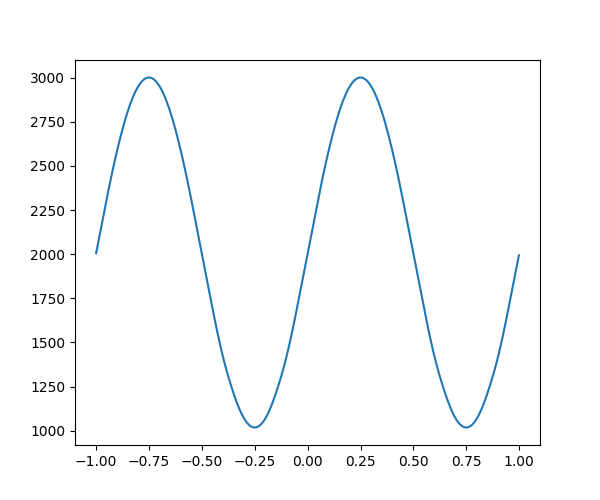

In [21]:

fig, axis = plt.subplots(1, 1, figsize = (6,5), squeeze = False)

# axis[0,0].scatter(particles[:,0], particles[:,0] * 0, s = 1)
axis[0,0].plot(perennialState['fluid']['positions'], torchDensity)